In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker
import requests
from sklearn.metrics import r2_score
import catboost
import re
import sys
sys.path.append('.')

In [4]:
from src.utils import collect_data
collect_datasets = collect_data.DataCollection()
df_mobility = collect_datasets.get_mobility_data()
df_county_spend = collect_datasets.get_spend_data()
df_covid = collect_datasets.combine_covid_data()
df_weather = collect_datasets.combine_weather(df_mobility,df_covid)

In [5]:
df_county_demo = collect_datasets.combined_county_data()

In [6]:
df_county_demo

,YEAR,STATE,COUNTY,NAME_E,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,fips,AKGVE001,party,pct_republican
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,0.486848,0.032409,0.036612,0.031775,0.022754,...,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,01001,0.4602,republican,0.753775
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,0.486231,0.028135,0.026674,0.036251,0.019865,...,0.105250,0.085579,0.073092,0.064413,0.190974,0.142761,01003,0.4609,republican,0.797922
2,2014-2018,Alabama,Barbour County,"Barbour County, Alabama",25782,0.531262,0.027810,0.026026,0.035374,0.018385,...,0.091089,0.062324,0.031021,0.080090,0.215454,0.183023,01005,0.4731,republican,0.528232
3,2014-2018,Alabama,Bibb County,"Bibb County, Alabama",22527,0.539442,0.030719,0.028899,0.030630,0.024016,...,0.099707,0.095601,0.039296,0.031085,0.203519,0.199413,01007,0.4294,republican,0.782397
4,2014-2018,Alabama,Blount County,"Blount County, Alabama",57645,0.493260,0.031451,0.029369,0.036742,0.021077,...,0.109925,0.072905,0.061549,0.055417,0.140586,0.221894,01009,0.4331,republican,0.913812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,2014-2018,Puerto Rico,Vega Baja Municipio,"Vega Baja Municipio, Puerto Rico",53371,0.479287,0.023777,0.024358,0.037061,0.020910,...,0.047218,0.031750,0.061872,0.027680,0.115332,0.503392,72145,0.5095,NaN,0.666682
3216,2014-2018,Puerto Rico,Vieques Municipio,"Vieques Municipio, Puerto Rico",8771,0.493900,0.032835,0.031239,0.024969,0.007297,...,0.047198,0.017699,0.008850,0.000000,0.244838,0.433628,72147,0.4542,NaN,0.666682
3217,2014-2018,Puerto Rico,Villalba Municipio,"Villalba Municipio, Puerto Rico",22993,0.485757,0.028313,0.033141,0.029661,0.025312,...,0.094323,0.052302,0.016540,0.017881,0.088511,0.537774,72149,0.5172,NaN,0.666682
3218,2014-2018,Puerto Rico,Yabucoa Municipio,"Yabucoa Municipio, Puerto Rico",34149,0.484377,0.022080,0.032065,0.029869,0.020908,...,0.016399,0.027847,0.028775,0.029084,0.155322,0.617265,72151,0.5104,NaN,0.666682


In [7]:
def get_model_df(df_weather, df_mob,df_covid,df_demographics):
    df_mob_covid = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='outer')
    df_mob_covid = df_mob_covid.dropna(subset=['Lat'])
    df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
    df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['STATE', 'COUNTY']), right = df_demographics, on = ['fips'])
    # Removing the dates before March 1 for mobility predictions
    df_all_mob = df_all[(df_all.date >= df_mobility.date.min()) 
                                                & (df_all.date <= df_mobility.date.max())]

    df_mob_train = df_all_mob.dropna()
    return df_mob_train

In [8]:
def run_model(df,name,task_type='GPU',max_depth= 6):
    remove_cols = ['date','fips', 'samples','COUNTY','m50_index', 'Lat', 'Lng','YEAR','NAME_E' ]
    target_var = ['m50']
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var)
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth,devices='0',learning_rate=0.3,verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


0:	learn: 5.5352700	total: 104ms	remaining: 1m 43s
200:	learn: 1.9128983	total: 8.54s	remaining: 33.9s
400:	learn: 1.5176536	total: 16.8s	remaining: 25.2s
600:	learn: 1.2914760	total: 25.1s	remaining: 16.7s
800:	learn: 1.1207017	total: 33.5s	remaining: 8.32s
999:	learn: 0.9937677	total: 41.6s	remaining: 0us
0.85


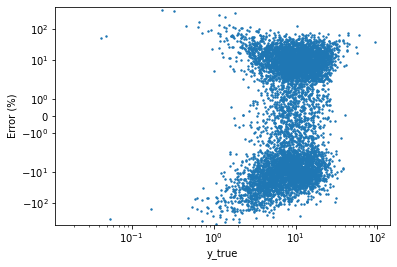

,Pre_Covid_Feature_Importance
Travel Time to Work_10 to 14 minutes,9.385562
STATE,7.436415
weekday,6.430331
Travel Time to Work_5 to 9 minutes,3.704172
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,3.636812
Median Household Income in the Past 12 Months (in 2018 Inflation-Adjusted Dollars)_Median household income in the past 12 months (in 2018 inflation-adjusted dollars),3.160086
mintempC,2.451888
Travel Time to Work_15 to 19 minutes,2.034850
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,1.880247
Means of Transportation to Work_Taxicab,1.858289


In [9]:
df_mob_train = get_model_df(df_weather, df_mobility,df_covid,df_county_demo)
df_mob_train_pre = df_mob_train[df_mob_train.date < '2020-03-15']
df_mob_train_pre = df_mob_train_pre[df_mob_train_pre.m50<100]
df_mob_pre_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_pre,name = 'Pre', task_type='CPU',max_depth = 6)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

Total Rows Test Dataset 7337 ||| Records with over 200% error 40


,error_pct,Count
STATE,,
Alaska,-30.736458,3
Vermont,-10.757631,29
Nevada,-9.403660,29
Idaho,-6.377111,87
Wyoming,-5.429830,48
New Hampshire,-4.947719,29
South Dakota,-4.658027,56
Connecticut,-2.809181,25
Kansas,-2.418662,150


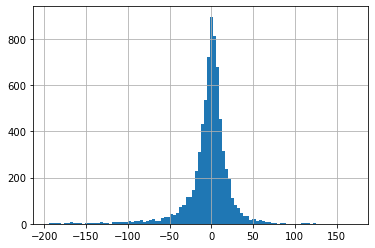

In [10]:
pd.options.mode.chained_assignment = None
y_test['pred']= y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_pre.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')

0:	learn: 4.8337359	total: 283ms	remaining: 4m 43s
200:	learn: 2.0270514	total: 43.4s	remaining: 2m 52s
400:	learn: 1.7947008	total: 1m 28s	remaining: 2m 11s
600:	learn: 1.6638934	total: 2m 11s	remaining: 1m 27s
800:	learn: 1.5674915	total: 2m 54s	remaining: 43.4s
999:	learn: 1.4905006	total: 3m 38s	remaining: 0us
0.85


c:\users\swami\anaconda3\envs\base_env\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


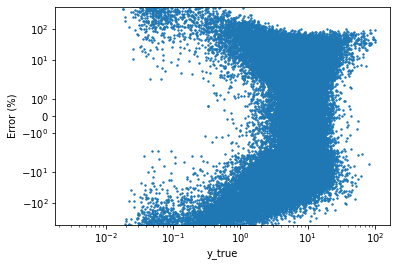

,Post_Covid_Feature_Importance
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,8.659970
weekday,5.083628
Travel Time to Work_10 to 14 minutes,5.061682
case_rate,4.971770
STATE,3.893658
Travel Time to Work_5 to 9 minutes,3.317464
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,3.109858
"Means of Transportation to Work_Car, truck, or van",2.397362
FeelsLikeC,1.969542
weekend,1.956026


In [11]:
df_mob_train_covid = df_mob_train[df_mob_train.date >= '2020-03-15']
df_mob_train_covid = df_mob_train_covid[df_mob_train_covid.m50<100]
df_mob_covid_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_covid,task_type='CPU',name='Post',max_depth = 8)
df_mob_covid_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

Total Rows Test Dataset 101909 ||| Records with over 200% error 4009


,error_pct,Count
STATE,,
Alabama,-0.011227,2577
Alaska,6.729651,40
Arizona,-3.228178,547
Arkansas,-0.013761,2674
California,1.669369,2093
Colorado,-1.076599,1657
Connecticut,1.609836,322
Delaware,4.195725,123
Florida,0.169635,2814


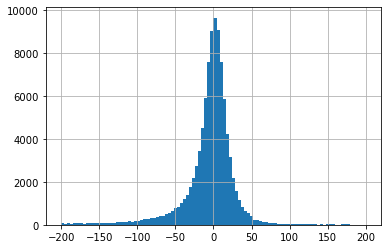

In [12]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_covid.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], axis=1)